In [ ]:
#upload file csv
from google.colab import files
uploaded = files.upload()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# membaca file csv
df = pd.read_csv("/content/spam_assasin.csv")
df.head(5)

,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0


## Memulai tahapan preprocessing pada teks

In [ ]:
import re
# menggunakan re untuk menghilangkan karakter khusus seperti tanda baca dan spasi berlebih
text_with_special_chars = "Hello! How are you?    123 This is an example with special characters."
cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text_with_special_chars)
cleaned_text = re.sub(r'\s+', " ",cleaned_text).strip().lower()
cleaned_text

'hello how are you 123 this is an example with special characters'

In [ ]:
# membuat fungsi untuk clean text
def clean_text(text):
  cleaned_text = re.sub(r"[^a-zA-Z0-9\s:']", ' ', text)
  cleaned_text = re.sub(r'\s+', " ",cleaned_text).strip().lower()
  return cleaned_text


In [ ]:
df = df.dropna(subset=['text'])
df['cleaned_text'] = df["text"].apply(clean_text)
df.head(5)

,text,target,cleaned_text
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0,from ilug admin linux ie mon jul 29 11:28:02 2...
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1,from gort44 excite com mon jun 24 17:54:21 200...
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1,from fork admin xent com mon jul 29 11:39:57 2...
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1,from dcm123 btamail net cn mon jun 24 17:49:23...
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0,from ilug admin linux ie mon aug 19 11:02:47 2...


In [ ]:
# melakukan tokenisasi
df['tokenized_text'] = df['cleaned_text'].apply(lambda x: x.split())
df.head(5)

,text,target,cleaned_text,tokenized_text
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0,from ilug admin linux ie mon jul 29 11:28:02 2...,"[from, ilug, admin, linux, ie, mon, jul, 29, 1..."
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1,from gort44 excite com mon jun 24 17:54:21 200...,"[from, gort44, excite, com, mon, jun, 24, 17:5..."
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1,from fork admin xent com mon jul 29 11:39:57 2...,"[from, fork, admin, xent, com, mon, jul, 29, 1..."
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1,from dcm123 btamail net cn mon jun 24 17:49:23...,"[from, dcm123, btamail, net, cn, mon, jun, 24,..."
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0,from ilug admin linux ie mon aug 19 11:02:47 2...,"[from, ilug, admin, linux, ie, mon, aug, 19, 1..."


In [ ]:
# Ubah teks menjadi vektor dengan Word2Vec CBOW
# link referensi: https://medium.com/@afrizalfir/mengenal-word2vec-af4758da6b5d

from gensim.models import Word2Vec
word2vec_model = Word2Vec(sentences=df['tokenized_text'], vector_size=100, window=5, min_count=1, sg=0)  # sg=0 for CBOW
# Fungsi untuk mengubah setiap teks tokenisasi menjadi vektor fitur

def text_to_vector(text):
    if not text:
        return None  # Mengembalikan None jika daftar token kosong

    vector_sum = 0
    for word in text:
        if word in word2vec_model.wv:
            vector_sum += word2vec_model.wv[word]

    # Periksa apakah vektor jumlahnya nol untuk menghindari pembagian dengan nol
    if vector_sum.any():
        return vector_sum / len(text)  # Menghitung vektor rata-rata
    else:
        return None  # Mengembalikan None jika vektor jumlahnya nol

# Mengubah setiap teks tokenisasi menjadi vektor fitur
df['word2vec_cbow_vector'] = df['tokenized_text'].apply(text_to_vector)
df.head()

,text,target,cleaned_text,tokenized_text,word2vec_cbow_vector
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0,from ilug admin linux ie mon jul 29 11:28:02 2...,"[from, ilug, admin, linux, ie, mon, jul, 29, 1...","[0.2113976, -0.54752344, -0.15488116, 0.564253..."
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1,from gort44 excite com mon jun 24 17:54:21 200...,"[from, gort44, excite, com, mon, jun, 24, 17:5...","[0.29793826, -0.2014802, -0.48623696, 0.667415..."
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1,from fork admin xent com mon jul 29 11:39:57 2...,"[from, fork, admin, xent, com, mon, jul, 29, 1...","[-0.48598292, -0.4500029, -0.44243786, 0.77675..."
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1,from dcm123 btamail net cn mon jun 24 17:49:23...,"[from, dcm123, btamail, net, cn, mon, jun, 24,...","[-0.5669221, -0.35812813, -0.38906518, 0.43256..."
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0,from ilug admin linux ie mon aug 19 11:02:47 2...,"[from, ilug, admin, linux, ie, mon, aug, 19, 1...","[-0.15145847, -0.6898252, 0.0015950369, 0.5693..."


In [ ]:
null_values = df[df['word2vec_cbow_vector'].isna()]
# Cetak baris-baris yang memiliki nilai None dalam kolom 'word2vec_cbow_vector'
print(null_values)

df_cleaned = df.dropna(subset=['word2vec_cbow_vector'])
df_cleaned.head()

Empty DataFrame
Columns: [text, target, cleaned_text, tokenized_text, word2vec_cbow_vector]
Index: []


,text,target,cleaned_text,tokenized_text,word2vec_cbow_vector
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0,from ilug admin linux ie mon jul 29 11:28:02 2...,"[from, ilug, admin, linux, ie, mon, jul, 29, 1...","[0.2113976, -0.54752344, -0.15488116, 0.564253..."
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1,from gort44 excite com mon jun 24 17:54:21 200...,"[from, gort44, excite, com, mon, jun, 24, 17:5...","[0.29793826, -0.2014802, -0.48623696, 0.667415..."
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1,from fork admin xent com mon jul 29 11:39:57 2...,"[from, fork, admin, xent, com, mon, jul, 29, 1...","[-0.48598292, -0.4500029, -0.44243786, 0.77675..."
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1,from dcm123 btamail net cn mon jun 24 17:49:23...,"[from, dcm123, btamail, net, cn, mon, jun, 24,...","[-0.5669221, -0.35812813, -0.38906518, 0.43256..."
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0,from ilug admin linux ie mon aug 19 11:02:47 2...,"[from, ilug, admin, linux, ie, mon, aug, 19, 1...","[-0.15145847, -0.6898252, 0.0015950369, 0.5693..."


In [ ]:
print(df_cleaned["target"].value_counts())

0    3627
1    1686
Name: target, dtype: int64


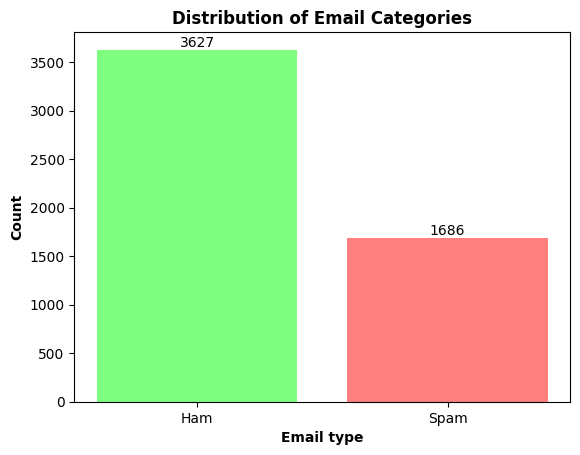

In [ ]:
# plotting jumlah category

ham_count = df_cleaned["target"].value_counts()[0]
spam_count = df_cleaned["target"].value_counts()[1]

plt.bar(["Ham"], [ham_count], color="#7FFF7F")  # pastel green
plt.bar(["Spam"], [spam_count], color='#FF7F7F')  # pastel red


plt.text(0, ham_count, str(ham_count), ha='center', va='bottom')
plt.text(1, spam_count, str(spam_count), ha='center', va='bottom')

plt.ylabel('Count', weight="bold")
plt.xlabel("Email type", weight="bold")
plt.title('Distribution of Email Categories', weight="bold")

plt.show()

In [ ]:
print(df_cleaned[df_cleaned["target"] == 1].shape)
df_cleaned[df_cleaned["target"] == 1].head(10)

(1686, 5)


,text,target,cleaned_text,tokenized_text,word2vec_cbow_vector
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1,from gort44 excite com mon jun 24 17:54:21 200...,"[from, gort44, excite, com, mon, jun, 24, 17:5...","[0.29793826, -0.2014802, -0.48623696, 0.667415..."
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1,from fork admin xent com mon jul 29 11:39:57 2...,"[from, fork, admin, xent, com, mon, jul, 29, 1...","[-0.48598292, -0.4500029, -0.44243786, 0.77675..."
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1,from dcm123 btamail net cn mon jun 24 17:49:23...,"[from, dcm123, btamail, net, cn, mon, jun, 24,...","[-0.5669221, -0.35812813, -0.38906518, 0.43256..."
5,From tobaccodemon@terra.es Sat Sep 7 22:05:58 ...,1,from tobaccodemon terra es sat sep 7 22:05:58 ...,"[from, tobaccodemon, terra, es, sat, sep, 7, 2...","[-0.12856103, -0.63385886, -0.27215964, 0.6171..."
6,From larlar78@MailOps.Com Sat Jun 30 00:19:08 ...,1,from larlar78 mailops com sat jun 30 00:19:08 ...,"[from, larlar78, mailops, com, sat, jun, 30, 0...","[-0.22502023, -0.43716362, -0.22774199, 0.5674..."
9,From contractor@goldenbay.com.cy Tue Jul 23 23...,1,from contractor goldenbay com cy tue jul 23 23...,"[from, contractor, goldenbay, com, cy, tue, ju...","[-0.40826902, 0.20945314, -1.3321462, 0.500063..."
13,From johnokele@truthmail.com Wed Sep 11 14:10:...,1,from johnokele truthmail com wed sep 11 14:10:...,"[from, johnokele, truthmail, com, wed, sep, 11...","[0.5689448, -0.10587852, -0.37267274, 0.507389..."
14,From traci17fbi@yahoo.com Mon Jul 2 01:38:18 2...,1,from traci17fbi yahoo com mon jul 2 01:38:18 2...,"[from, traci17fbi, yahoo, com, mon, jul, 2, 01...","[-0.08008789, -0.025352398, -0.81711197, 0.686..."
15,Return-Path: <root@mail9.aweber.com> Received:...,1,return path: root mail9 aweber com received: f...,"[return, path:, root, mail9, aweber, com, rece...","[-0.12299516, -0.034228116, -0.33365285, 0.511..."
16,From gsl@insurancemail.net Mon Jun 24 17:06:12...,1,from gsl insurancemail net mon jun 24 17:06:12...,"[from, gsl, insurancemail, net, mon, jun, 24, ...","[0.068790615, 0.11403034, -0.6743282, 0.239483..."


In [ ]:
print(df_cleaned[df_cleaned["target"] == 0].shape)
df_cleaned[df_cleaned["target"] == 0].head(10)

(3627, 5)


,text,target,cleaned_text,tokenized_text,word2vec_cbow_vector
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0,from ilug admin linux ie mon jul 29 11:28:02 2...,"[from, ilug, admin, linux, ie, mon, jul, 29, 1...","[0.2113976, -0.54752344, -0.15488116, 0.564253..."
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0,from ilug admin linux ie mon aug 19 11:02:47 2...,"[from, ilug, admin, linux, ie, mon, aug, 19, 1...","[-0.15145847, -0.6898252, 0.0015950369, 0.5693..."
7,From rpm-list-admin@freshrpms.net Thu Jul 25 1...,0,from rpm list admin freshrpms net thu jul 25 1...,"[from, rpm, list, admin, freshrpms, net, thu, ...","[0.046577275, -0.50806093, -0.4045175, 0.43027..."
8,From exmh-users-admin@redhat.com Wed Aug 7 06:...,0,from exmh users admin redhat com wed aug 7 06:...,"[from, exmh, users, admin, redhat, com, wed, a...","[-0.10686082, -0.6464011, -0.8279674, 1.246170..."
10,From rssfeeds@jmason.org Fri Oct 4 11:02:10 20...,0,from rssfeeds jmason org fri oct 4 11:02:10 20...,"[from, rssfeeds, jmason, org, fri, oct, 4, 11:...","[0.43270746, -0.609181, -0.49084693, 0.5004101..."
11,From ilug-admin@linux.ie Tue Aug 13 10:29:44 2...,0,from ilug admin linux ie tue aug 13 10:29:44 2...,"[from, ilug, admin, linux, ie, tue, aug, 13, 1...","[-0.24640547, -0.72546333, -0.115510926, 0.589..."
12,From rpm-list-admin@freshrpms.net Thu Aug 29 1...,0,from rpm list admin freshrpms net thu aug 29 1...,"[from, rpm, list, admin, freshrpms, net, thu, ...","[0.3264988, -0.36782044, -0.32012138, 0.401899..."
17,From rpm-list-admin@freshrpms.net Mon Jul 22 1...,0,from rpm list admin freshrpms net mon jul 22 1...,"[from, rpm, list, admin, freshrpms, net, mon, ...","[0.001229449, -0.47543302, -0.29114342, 0.5787..."
18,From info@evilgerald.com Tue Aug 6 11:17:56 20...,0,from info evilgerald com tue aug 6 11:17:56 20...,"[from, info, evilgerald, com, tue, aug, 6, 11:...","[-0.29956347, -0.52251625, -0.17104487, 0.3526..."
19,From spamassassin-talk-admin@lists.sourceforge...,0,from spamassassin talk admin lists sourceforge...,"[from, spamassassin, talk, admin, lists, sourc...","[-0.1874775, -0.8067384, -0.45157155, 0.669970..."


## Memulai tahap training dengan random forest

In [ ]:
# Persiapan Data
X = df_cleaned['word2vec_cbow_vector'].values
y = df_cleaned['target'].values

# Bagi data menjadi set pelatihan dan set pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan Latih Model Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=2,random_state=42)
rf_model.fit(X_train.tolist(), y_train)

# Prediksi menggunakan set pengujian
y_pred = rf_model.predict(X_test.tolist())

# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9821260583254939
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       701
           1       0.99      0.96      0.97       362

    accuracy                           0.98      1063
   macro avg       0.98      0.98      0.98      1063
weighted avg       0.98      0.98      0.98      1063



In [ ]:
output = pd.DataFrame({"Model": ['Random Forest'],
                       "Accuracy": [accuracy * 100]})

<ipython-input-22-54ce059f5376>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = sns.barplot(x='Model', y='Accuracy', data=output, palette=custom_colors)


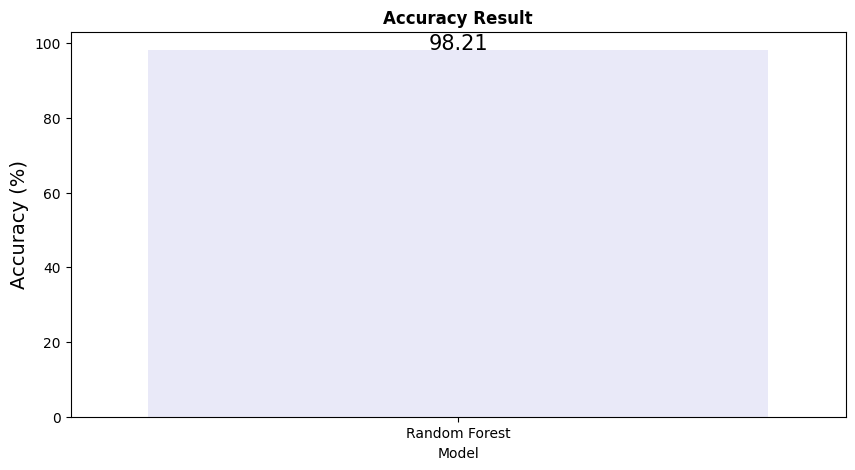

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 5))
custom_colors = ['lavender']
plots = sns.barplot(x='Model', y='Accuracy', data=output, palette=custom_colors)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points')
plt.title("Accuracy Result", weight="bold")
plt.ylabel("Accuracy (%)", size=14)
plt.show()

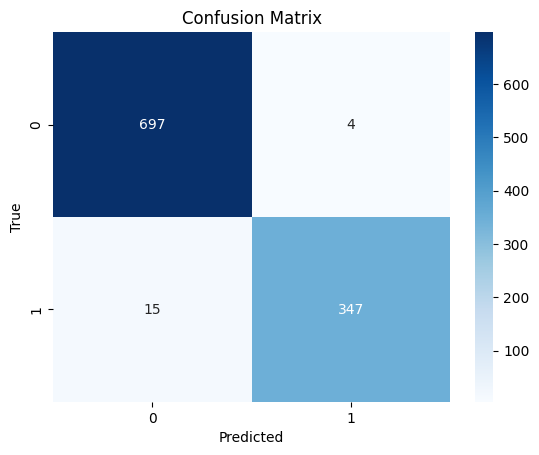

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    cleaned_text = text.lower()
    # Remove punctuation and special characters
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    return cleaned_text

# Example input
email_text = input("Enter the email text: ")

# Clean the input text
cleaned_text = clean_text(email_text)

# Tokenize the cleaned text
tokenized_text = cleaned_text.split()

# Assuming you have trained the RandomForestClassifier model and stored it in rf_model
# Example: rf_model = RandomForestClassifier()
# Train your model on your dataset before using it for prediction

# Calculate CBOW vector for the input text
def text_to_cbow_vector(text):
    if not text:
        return np.zeros(100)  # Return zero vector if text is empty

    vector_sum = np.zeros(100)
    for word in text:
        if word in word2vec_model.wv:
            vector_sum += word2vec_model.wv[word]

    # Check if the sum of vectors is non-zero to avoid division by zero
    if not np.all(vector_sum == 0):
        return vector_sum / len(text)  # Calculate the average vector
    else:
        return np.zeros(100)  # Return zero vector if the sum is zero

# Calculate CBOW vector for the input text
input_text_vector = text_to_cbow_vector(tokenized_text).reshape(1, -1)

# Make predictions using the RandomForestClassifier model
predicted_class = rf_model.predict(input_text_vector)

# Define classes
classes = ["Ham", "Spam"]

# Now you have the predicted class for the input text
predicted_class = classes[predicted_class[0]]

print("Predicted class:", predicted_class)


Enter the email text: Hi team,  Just a reminder that we have a meeting scheduled for tomorrow at 10:00 AM in the conference room. We'll be discussing the upcoming project deadlines and assigning tasks. Please make sure to attend on time.  Thanks, John
Predicted class: Ham


In [ ]:
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    cleaned_text = text.lower()
    # Remove punctuation and special characters
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    return cleaned_text

# Example input
email_text = input("Enter the email text: ")

# Clean the input text
cleaned_text = clean_text(email_text)

# Tokenize the cleaned text
tokenized_text = cleaned_text.split()

# Assuming you have trained the RandomForestClassifier model and stored it in rf_model
# Example: rf_model = RandomForestClassifier()
# Train your model on your dataset before using it for prediction

# Calculate CBOW vector for the input text
def text_to_cbow_vector(text):
    if not text:
        return np.zeros(100)  # Return zero vector if text is empty

    vector_sum = np.zeros(100)
    for word in text:
        if word in word2vec_model.wv:
            vector_sum += word2vec_model.wv[word]

    # Check if the sum of vectors is non-zero to avoid division by zero
    if not np.all(vector_sum == 0):
        return vector_sum / len(text)  # Calculate the average vector
    else:
        return np.zeros(100)  # Return zero vector if the sum is zero

# Calculate CBOW vector for the input text
input_text_vector = text_to_cbow_vector(tokenized_text).reshape(1, -1)

# Make predictions using the RandomForestClassifier model
predicted_class = rf_model.predict(input_text_vector)

# Define classes
classes = ["Ham", "Spam"]

# Now you have the predicted class for the input text
predicted_class = classes[predicted_class[0]]

print("Predicted class:", predicted_class)


Enter the email text: Congratulations!  You've been selected as one of our lucky winners! Claim your prize now by clicking on the link below. You have only 24 hours to claim your reward, so act fast!  Click here to claim your prize: [spammylink.com]  Don't miss out on this amazing opportunity!  Best regards, Spammy Marketing Team
Predicted class: Spam
